In [19]:
import json
import os
import torch
from torch import nn, optim
from tqdm import tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset, DataLoader

In [209]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [210]:
def read_json_file(filename):
    with open(filename, 'r') as file:
        data = json.load(file)
    return data


In [223]:
# Initialize lists to store integrated segments (X) and labels (y)
X = []
y = []

In [224]:
# Define the filename
filename = "Siddharth_ECG.json"

# Read the JSON file
data = read_json_file(filename)

# Extract integrated segments and labels from the data
for segment_data in data:
    integrated_segment = segment_data["integrated_segment"]
    label = segment_data["label"]
    X.append(integrated_segment)
    y.append(label)

In [197]:
filename = "Zeyu_ECG.json"
data = read_json_file(filename)

# Extract integrated segments and labels from the data
for segment_data in data:
    integrated_segment = segment_data["integrated_segment"]
    label = segment_data["label"]
    X.append(integrated_segment)
    y.append(label)

In [225]:
max_length = 1000

In [226]:
padded_X = []
for segment in X:
    pad_length = max_length - len(segment)
    padded_segment = np.pad(segment, (0, pad_length), mode='edge')  # Padding with the last observed value
    padded_X.append(padded_segment)
# Convert padded_X to a numpy array
padded_X = np.array(padded_X)

# Print the shape of padded_X to verify
print("Shape of padded_X:", padded_X.shape)

Shape of padded_X: (2558, 1000)


In [227]:
from sklearn.model_selection import train_test_split
_X = torch.tensor(padded_X, dtype=torch.float32).to(device)
_y = torch.tensor(y, dtype=torch.float32).view(-1, 1).to(device)
X_train, X_test, y_train, y_test = train_test_split(_X, _y, test_size=0.3, random_state=1437)

In [228]:
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=5, shuffle=True)
val_dataset = TensorDataset(X_test, y_test)
val_loader = DataLoader(val_dataset, batch_size=5, shuffle=True)

In [106]:
class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.hidden_size = hidden_size
        self.attn = nn.Linear(hidden_size * 2, hidden_size)
        self.v = nn.Linear(hidden_size, 1, bias=False)
        
    def forward(self, encoder_outputs):
        # encoder_outputs: [batch_size, seq_len, hidden_size * 2]
        energy = torch.tanh(self.attn(encoder_outputs))
        attention_scores = self.v(energy).squeeze(2)  # [batch_size, seq_len]
        attention_weights = torch.softmax(attention_scores, dim=1)
        context_vector = torch.bmm(attention_weights.unsqueeze(1), encoder_outputs).squeeze(1)
        return context_vector, attention_weights


class BiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(BiLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.attention = Attention(hidden_size)
        self.fc1 = nn.Linear(hidden_size*2, 256) 
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)
        self.drop = nn.Dropout(0.5)
        self.relu = nn.LeakyReLU(0.1)

        
    def forward(self, x):
        # Set initial hidden and cell states
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device) # 2 for bidirection 
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size*2)
        context_vector, attention_weights = self.attention(out)
        # Decode the hidden state of the last time step
        # out = self.fc1(out[:, -1, :])
        out = self.fc1(context_vector)
        out = self.drop(self.relu(out))
        out = self.drop(self.relu(self.fc2(out)))
        out = self.relu(self.fc3(out))
        return out

In [229]:
class FCClassifier(nn.Module):
    def __init__(self, input_dim):
        super(FCClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 2)
        self.dropout = nn.Dropout(0.5)
        self.non_lin = nn.LeakyReLU(0.2)

    def forward(self, x):
        x = self.non_lin(self.fc1(x))
        x = self.dropout(x)
        x = self.non_lin(self.fc2(x))
        x = self.dropout(x)
        x = self.non_lin(self.fc3(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc4(x))
        return x

In [230]:
model = FCClassifier(input_dim=max_length).to(device)

In [231]:
from sklearn.utils.class_weight import compute_class_weight

# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(np.array([0, 1])), y=y)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)
print(class_weights)

tensor([1.4180, 0.7723], device='cuda:0')


In [232]:
from torch.optim import lr_scheduler
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.2)
train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []
train_f1s = []
val_f1s = []

In [234]:
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
def train(model, train_loader, val_loader, criterion, optimizer, epochs=20):

    for epoch in range(epochs):
        model.train()
        running_train_loss = 0.0
        correct_train = 0
        total_train = 0
        train_predictions = []
        train_labels = []
        # Training loop
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            labels_onehot = F.one_hot(labels.long(), num_classes=2).squeeze(1).type(torch.float32)
            loss = criterion(outputs, labels_onehot)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()

            # Compute training accuracy
            prediction = torch.argmax(outputs, dim=1).cpu().detach().numpy()
            expected = torch.argmax(labels_onehot, dim=1).cpu().detach().numpy()
            correct_train += (prediction == expected).sum().item()
            total_train += labels.size(0)
            train_predictions.extend(prediction)
            train_labels.extend(expected)

        
        train_loss = running_train_loss / len(train_loader)
        train_accuracy = correct_train / total_train
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        train_f1_score = f1_score(train_labels, train_predictions)
        train_f1s.append(train_f1_score)
        
        # Validation loop
        model.eval()
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0
        val_predictions = []
        val_labels = []
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                labels_onehot = F.one_hot(labels.long(), num_classes=2).squeeze(1).type(torch.float32)
                loss = criterion(outputs, labels_onehot)
                running_val_loss += loss.item()

                # Compute validation accuracy
                prediction = torch.argmax(outputs, dim=1).cpu().detach().numpy()
                expected = torch.argmax(labels_onehot, dim=1).cpu().detach().numpy()
                correct_val += (prediction == expected).sum().item()
                total_val += labels.size(0)
                val_predictions.extend(prediction)
                val_labels.extend(expected)
        
        val_loss = running_val_loss / len(val_loader)
        val_accuracy = correct_val / total_val
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        val_f1_score = f1_score(val_labels, val_predictions)
        val_f1s.append(val_f1_score)
        
        if val_f1_score == max(val_f1s):
            torch.save(model.state_dict(), 'Siddharth_fc1000_hif1.pth')
        if val_loss == min(val_losses):
            torch.save(model.state_dict(), 'Siddharth_fc1000_minls.pth')

        print(f"Epoch {epoch+1}/{epochs}, "
      f"Train Loss: {train_loss:.4f}, "
      f"Train Accuracy: {train_accuracy:.4f}, "
      f"Train F1 Score: {train_f1_score:.4f}, "
      f"Val Loss: {val_loss:.4f}, "
      f"Val Accuracy: {val_accuracy:.4f}, "
      f"Val F1 Score: {val_f1_score:.4f}")


In [235]:
train(model, train_loader, val_loader, criterion, optimizer, epochs=100)

Epoch 1/100, Train Loss: 0.6946, Train Accuracy: 0.4240, Train F1 Score: 0.3275, Val Loss: 0.6825, Val Accuracy: 0.3320, Val F1 Score: 0.0000
Epoch 2/100, Train Loss: 0.6954, Train Accuracy: 0.4665, Train F1 Score: 0.4285, Val Loss: 0.6838, Val Accuracy: 0.3320, Val F1 Score: 0.0000
Epoch 3/100, Train Loss: 0.6942, Train Accuracy: 0.4994, Train F1 Score: 0.5088, Val Loss: 0.6770, Val Accuracy: 0.5000, Val F1 Score: 0.4696
Epoch 4/100, Train Loss: 0.6913, Train Accuracy: 0.6022, Train F1 Score: 0.7266, Val Loss: 0.6721, Val Accuracy: 0.6680, Val F1 Score: 0.8009
Epoch 5/100, Train Loss: 0.6914, Train Accuracy: 0.6229, Train F1 Score: 0.7637, Val Loss: 0.6721, Val Accuracy: 0.6680, Val F1 Score: 0.8009
Epoch 6/100, Train Loss: 0.6870, Train Accuracy: 0.6330, Train F1 Score: 0.7715, Val Loss: 0.6751, Val Accuracy: 0.6667, Val F1 Score: 0.8000
Epoch 7/100, Train Loss: 0.6873, Train Accuracy: 0.6413, Train F1 Score: 0.7779, Val Loss: 0.6592, Val Accuracy: 0.6680, Val F1 Score: 0.8009
Epoch 

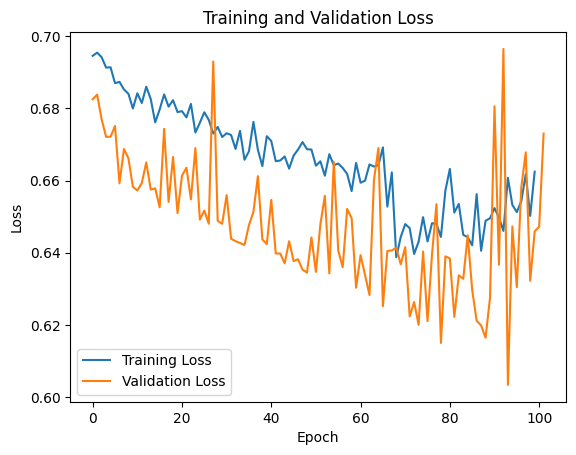

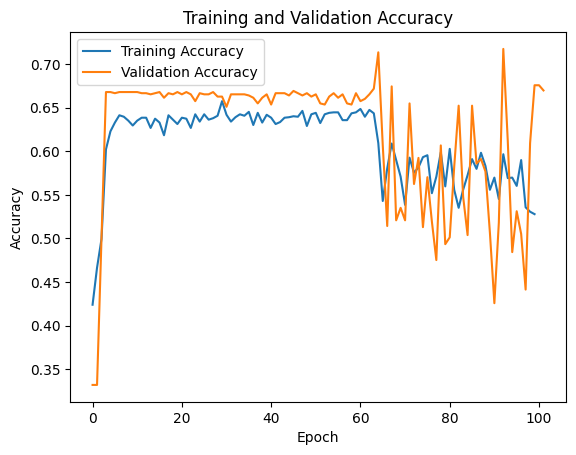

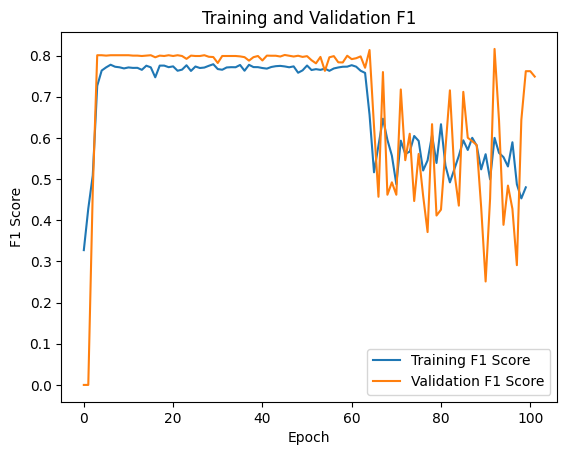

In [239]:
import matplotlib.pyplot as plt

def plot_loss(train_losses, val_losses):
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

def plot_accuracy(train_accuracies, val_accuracies):
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

def plot_f1s(train_f1s, val_f1s):
    plt.plot(train_f1s, label='Training F1 Score')
    plt.plot(val_f1s, label='Validation F1 Score')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.title('Training and Validation F1')
    plt.legend()
    plt.show()

# Assuming train_losses, train_accuracies, val_losses, val_accuracies are available
plot_loss(train_losses, val_losses)
plot_accuracy(train_accuracies, val_accuracies)
plot_f1s(train_f1s, val_f1s)

In [236]:
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
def plot_confusion_matrix(conf_matrix, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', cbar=False)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(title)
    plt.show()

def val(model, val_loader, criterion, epochs=20):

    for epoch in range(epochs):
        model.eval()
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0
        val_predictions = []
        val_labels = []
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                labels_onehot = F.one_hot(labels.long(), num_classes=2).squeeze(1).type(torch.float32)
                loss = criterion(outputs, labels_onehot)
                running_val_loss += loss.item()

                # Compute validation accuracy
                prediction = torch.argmax(outputs, dim=1).cpu().detach().numpy()
                expected = torch.argmax(labels_onehot, dim=1).cpu().detach().numpy()
                correct_val += (prediction == expected).sum().item()
                total_val += labels.size(0)
                val_predictions.extend(prediction)
                val_labels.extend(expected)
        
        val_loss = running_val_loss / len(val_loader)
        val_accuracy = correct_val / total_val
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        val_f1_score = f1_score(val_labels, val_predictions)
        val_f1s.append(val_f1_score)
        

        val_conf_matrix = confusion_matrix(val_labels, val_predictions)

        print("\nValidation Confusion Matrix:")
        plot_confusion_matrix(val_conf_matrix, title="Transfer Confusion Matrix")

        print(f"Epoch {epoch+1}/{epochs}, "
      f"Val Loss: {val_loss:.4f}, "
      f"Val Accuracy: {val_accuracy:.4f}, "
      f"Val F1 Score: {val_f1_score:.4f}")



Validation Confusion Matrix:


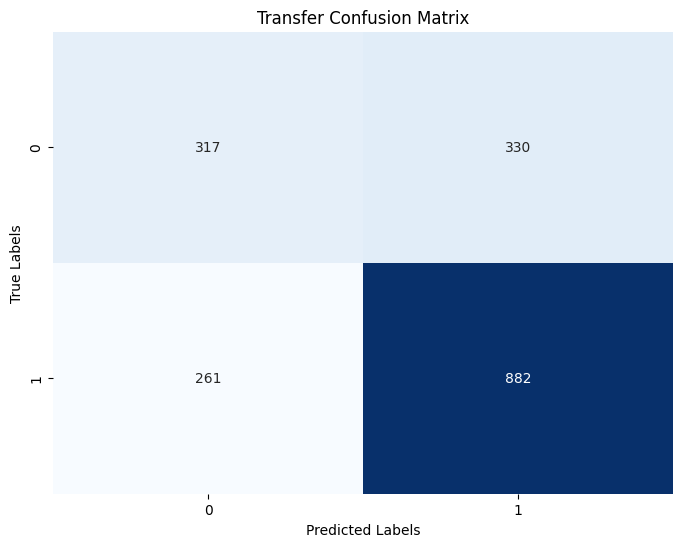

Epoch 1/1, Val Loss: 0.6730, Val Accuracy: 0.6698, Val F1 Score: 0.7490


In [238]:
val(model, train_loader, criterion, epochs=1)